In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import numpy as np
from imblearn.over_sampling import SMOTE

In [38]:
try:
    df = pd.read_csv('Delhi metro.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'Delhi metro.csv' not found. Please ensure the file is in the correct directory.")
    exit()
print(df.info())
print(df.head())
rows,columns= df.shape
print(f"Total Rows {rows} and Columns is {columns}")

Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID (Station ID)               285 non-null    int64  
 1   Station Names                 285 non-null    object 
 2   Dist. From First Station(km)  285 non-null    float64
 3   Metro Line                    285 non-null    object 
 4   Opened(Year)                  285 non-null    object 
 5   Layout                        285 non-null    object 
 6   Latitude                      285 non-null    float64
 7   Longitude                     285 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 17.9+ KB
None
   ID (Station ID)                 Station Names  \
0                1  Shaheed Sthal(First Station)   
1                2                  Hindon River   
2                3                       Arthala   
3   

In [39]:
df['Opened(Year)'] = pd.to_datetime(df['Opened(Year)'],format='%d-%m-%Y').dt.year
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID (Station ID)               285 non-null    int64  
 1   Station Names                 285 non-null    object 
 2   Dist. From First Station(km)  285 non-null    float64
 3   Metro Line                    285 non-null    object 
 4   Opened(Year)                  285 non-null    int32  
 5   Layout                        285 non-null    object 
 6   Latitude                      285 non-null    float64
 7   Longitude                     285 non-null    float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 16.8+ KB
None


In [40]:
missing_value = df.isnull().sum()
print(missing_value)

ID (Station ID)                 0
Station Names                   0
Dist. From First Station(km)    0
Metro Line                      0
Opened(Year)                    0
Layout                          0
Latitude                        0
Longitude                       0
dtype: int64


In [41]:
numerical_summary = df.describe()
print(numerical_summary)

       ID (Station ID)  Dist. From First Station(km)  Opened(Year)  \
count       285.000000                    285.000000    285.000000   
mean         16.214035                     19.218947   2012.578947   
std          11.461808                     14.002862      5.425382   
min           1.000000                      0.000000   2002.000000   
25%           6.000000                      7.300000   2009.000000   
50%          14.000000                     17.400000   2011.000000   
75%          24.000000                     28.800000   2018.000000   
max          49.000000                     52.700000   2019.000000   

         Latitude   Longitude  
count  285.000000  285.000000  
mean    28.595428   77.029315  
std      0.091316    2.875400  
min     27.920862   28.698807  
25%     28.545828   77.107130  
50%     28.613453   77.207220  
75%     28.666360   77.281165  
max     28.878965   77.554479  


In [42]:
df['Layout'].value_counts()

Layout
Elevated       214
Underground     68
At-Grade         3
Name: count, dtype: int64

In [43]:
# Filter At-Grade samples
at_grade_df = df[df['Layout'] == 'At-Grade']

# Number of synthetic samples to create
n_synthetic = 20

# Create synthetic samples by duplicating and adding small noise
synthetic_samples = at_grade_df.sample(n=n_synthetic, replace=True).copy()

# Add small noise to numerical columns
for col in ['Dist. From First Station(km)', 'Opened(Year)', 'Latitude', 'Longitude']:
    synthetic_samples[col] += np.random.normal(0, 0.1, size=n_synthetic)

# Append synthetic samples to the original DataFrame
df = pd.concat([df, synthetic_samples], ignore_index=True)

# Confirm new class distribution
print(df['Layout'].value_counts())

Layout
Elevated       214
Underground     68
At-Grade        23
Name: count, dtype: int64


C:\Users\harshal naik\AppData\Local\Temp\ipykernel_14572\1381476890.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(layouts))


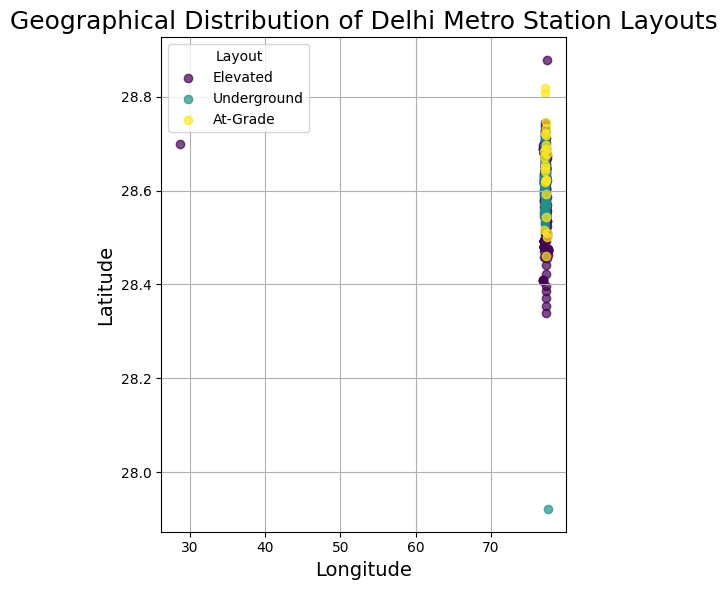

In [44]:
# Visualization: Geographical Distribution of Station Layouts
fig, ax = plt.subplots(figsize=(5, 6))
layouts = df['Layout'].unique()
colors = plt.cm.get_cmap('viridis', len(layouts))

for i, layout in enumerate(layouts):
    subset = df[df['Layout'] == layout]
    ax.scatter(subset['Longitude'], subset['Latitude'], label=layout, color=colors(i), alpha=0.7)

ax.set_title('Geographical Distribution of Delhi Metro Station Layouts', fontsize=18)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.legend(title='Layout')
ax.grid(True)
plt.tight_layout()
plt.show()

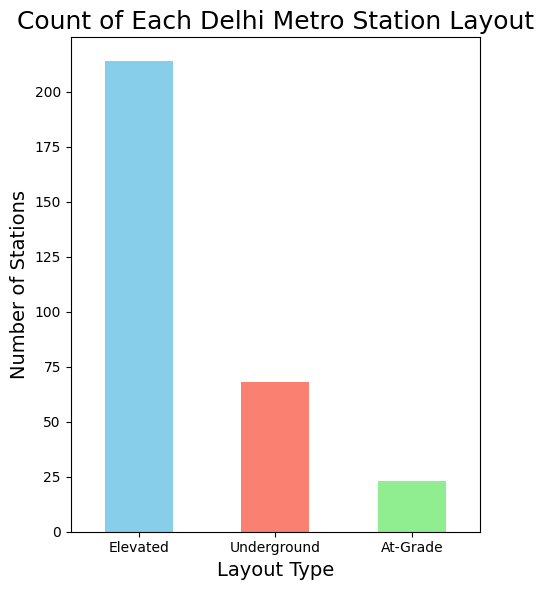

In [45]:
# Visualization 2.2: Bar Chart of Layout Counts
layout_counts = df['Layout'].value_counts()
plt.figure(figsize=(5, 6))
layout_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Count of Each Delhi Metro Station Layout', fontsize=18)
plt.xlabel('Layout Type', fontsize=14)
plt.ylabel('Number of Stations', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
#Machine Learning Model ---
print("\nStarting machine learning workflow...")
# Define features and target
features = ['Dist. From First Station(km)', 'Metro Line', 'Opened(Year)', 'Latitude', 'Longitude']
target = 'Layout'
X = df[features]
y = df[target]


Starting machine learning workflow...


In [47]:
# Identify categorical and numerical columns for preprocessing
categorical_features = ['Metro Line']
numerical_features = ['Dist. From First Station(km)', 'Opened(Year)', 'Latitude', 'Longitude']

In [48]:
# Create a preprocessor to handle different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

In [49]:
# Create the imblearn pipeline with SMOTE
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42, k_neighbors=3)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced'))
])

In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [51]:
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


In [52]:
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

In [53]:
# Evaluate the model's performance
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Model Evaluation:
Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

    At-Grade       1.00      1.00      1.00         4
    Elevated       0.95      0.95      0.95        43
 Underground       0.86      0.86      0.86        14

    accuracy                           0.93        61
   macro avg       0.94      0.94      0.94        61
weighted avg       0.93      0.93      0.93        61




Generating confusion matrix plot...
Saved confusion matrix plot as 'confusion_matrix.png'


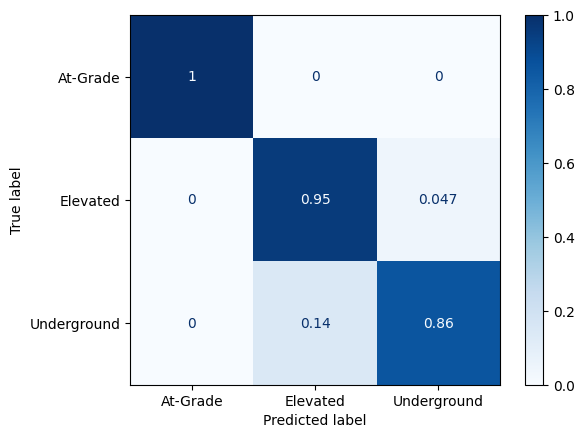

In [54]:
# Confusion Matrix Visualization ---
print("\nGenerating confusion matrix plot...")

# Create the confusion matrix plot
disp = ConfusionMatrixDisplay.from_estimator(
    model_pipeline,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize='true'
)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title('Normalized Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Saved confusion matrix plot as 'confusion_matrix.png'")
plt.close()